# Load dataset

In [10]:
from torchvision.datasets import CocoDetection, VisionDataset, wrap_dataset_for_transforms_v2
import json
import os
from typing import List, Any, Tuple
from PIL import Image
from torchvision.utils import draw_bounding_boxes
from torchvision.tv_tensors import Image as IMG, BoundingBoxes, BoundingBoxFormat
import torch
from torchvision.ops import box_convert
class MyCocoDetection(VisionDataset):
    def __init__(self, root, annFile, transform = None, target_transform = None, transforms = None):
        super().__init__(root, transforms, transform, target_transform)
        with open(annFile, 'r', encoding='utf-8') as f:
            self.coco = json.load(f)
        self.ids = sorted(self.coco['images'], key=lambda x: x['id'])

    def __len__(self):
        return len(self.ids)

    def _load_image(self, id: int) -> Image.Image:
        path = ""
        for ele in self.ids:
            if id == ele['id']:
                path = ele['file_name']
                break
        return IMG(Image.open(os.path.join(self.root, path)).convert("RGB"))

    def _load_target(self, id: int) -> List[Any]:
        for ele in self.coco['annotations']:
            if id == ele['image_id']:
                return ele

    def __getitem__(self, index: int) -> Tuple[Any, Any]:

        if not isinstance(index, int):
            raise ValueError(f"Index must be of type integer, got {type(index)} instead.")

        id = index
        image = self._load_image(id)
        target = self._load_target(id)

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, [target]
    
dataset = MyCocoDetection(root=r"C:\Users\Vitus\Downloads\hello.v3i.coco\val",
                        annFile=r"C:\Users\Vitus\Downloads\hello.v3i.coco\labels\val_1.json")

In [11]:
print(dataset[0])
print(dataset.coco['categories'])

img = IMG(dataset[0][0])
bbox = BoundingBoxes(dataset[0][1][0]['bbox'], format=BoundingBoxFormat.XYWH, canvas_size=img.shape[1:3])
bbox = box_convert(bbox, 'xywh', 'xyxy')
print(bbox)

draw = draw_bounding_boxes(image=img, boxes=bbox, labels=["1"], width=5, colors='green', fill=True)

(Image([[[31, 32, 33,  ..., 33, 39, 44],
        [18, 21, 23,  ..., 35, 38, 39],
        [15, 19, 24,  ..., 38, 35, 34],
        ...,
        [59, 67, 80,  ..., 55, 54, 53],
        [73, 78, 84,  ..., 47, 49, 52],
        [86, 87, 89,  ..., 45, 50, 56]],

       [[38, 41, 42,  ..., 41, 44, 49],
        [27, 30, 32,  ..., 43, 43, 44],
        [24, 28, 33,  ..., 46, 43, 42],
        ...,
        [48, 56, 69,  ..., 60, 57, 56],
        [62, 67, 73,  ..., 50, 52, 55],
        [75, 76, 78,  ..., 48, 53, 59]],

       [[22, 24, 25,  ..., 20, 24, 29],
        [10, 13, 15,  ..., 22, 23, 24],
        [ 7, 11, 16,  ..., 25, 22, 21],
        ...,
        [54, 62, 77,  ..., 38, 38, 37],
        [68, 73, 81,  ..., 31, 33, 36],
        [81, 82, 86,  ..., 29, 34, 40]]], dtype=torch.uint8, ), [{'id': 1, 'image_id': 0, 'category_id': 3, 'bbox': [279, 179, 232, 103], 'area': 23896, 'segmentation': [], 'iscrowd': 0}])
[{'id': 0, 'name': 'Air-F22'}, {'id': 1, 'name': 'Air-F35'}, {'id': 2, 'name': 'Grd-BM3

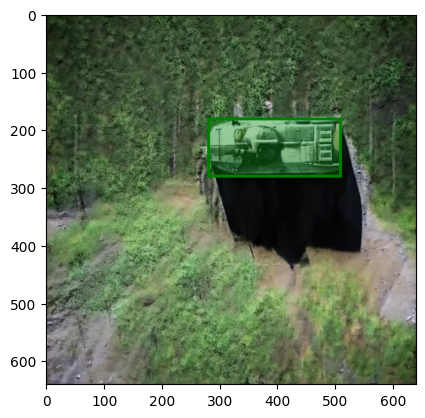

In [12]:
import matplotlib.pyplot as plt
plt.imshow(draw.permute(1,2,0))
plt.show()

# Luyện với torchvision

In [13]:
from torch.utils.data import DataLoader, random_split
from pytorch_lightning import seed_everything
seed_everything(42, workers=8, verbose=False)
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(
    dataset=dataset, lengths=[train_size, val_size])

train_dataloader = DataLoader(train_dataset, 1, True, num_workers=8)
val_dataloader = DataLoader(val_dataset, 1, False, num_workers=8)

c:\Users\Vitus\miniconda3\envs\mavclip\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.models.segmentation import deeplabv3_resnet50
model = fasterrcnn_mobilenet_v3_large_320_fpn(weights=None, weights_backbone=None, num_classes=len(dataset.coco['categories']))
model.to('cuda')
model.eval()
for inputs, targets in train_dataloader:
    print(inputs)